# Trackmodule 1: Modeling Basics in Python

## Important Libraries

In [1]:
from   scipy.integrate import solve_ivp    # allows to work with differential equations
import numpy as np                         # helps caluclating things
import matplotlib.pyplot as plt            # plots things

## Basic Models
### 1. Monod Model

The monod model is an unsegregated and unstructured simple model using the inputs:

$X_0   =$ initial cell density

$t    =$ time

$\mu_{max} =$ maximal specific growth rate                                                                                                       
                                                                                                                       
to determine the amount of cells at after a given time $X_t$ as shown in the equation below:

$X_t = X_0 \cdot e^ { t \cdot \mu_{max}} $

In [53]:
def monod_simple(x0,ymax,t):
    xt = x0*np.exp(ymax*t)
    return xt

monod_simple(x0 = 100, ymax= 0.2, t = 5)

271.8281828459045

Useing the Fuction abvoe one can determin the amount of cells overtime as follows.


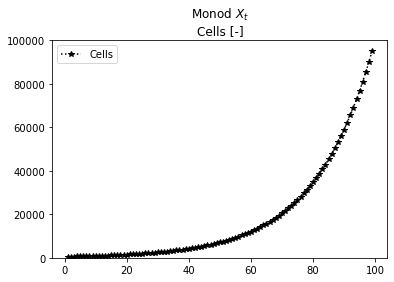

In [3]:
# Calculate the values
#---------------------
t    = np.arange(1,100)   #[h]
ymax = 0.053              #[h^-1]
x0   = 500                #[cells/L]
y    = monod_simple(x0 = x0, ymax = ymax,t = t)

# Plot the figure
#----------------
figure = plt.figure()                       # init figure
plt.plot(t,y, label = 'Cells', color = 'k', # plot add label change color
         marker = '*', linestyle = ':')     # marker and linestyle
plt.ylim((0,100000))                        # set limits for yaxis
plt.title('Monod $X_t$\nCells [-]')         # add title
plt.legend()                                # add legend
plt.show()                                  # make the plot visible

The above shown diagram is not sutable for more suffisticated descriptions of hte monod model. The influence of the Substrate uptakerate has an influence of the growthrate of the cells. Furthermore, the cells should display a deathrate overtime.

To calculate the amount of the current amount substrat the following equation can be used:

$S_t = S_0 - (X_0\cdot e^\mu_{max\cdot t} \cdot Y_{X/S})$

where as:

$S_t =$ the amount of avaiable Substrate at time $t$ 

$S_0 =$ the amount of initial Substrate

$Y_{X/S} =$ the Yield coefficient (new biomass $X$ / used Substrate $S$)


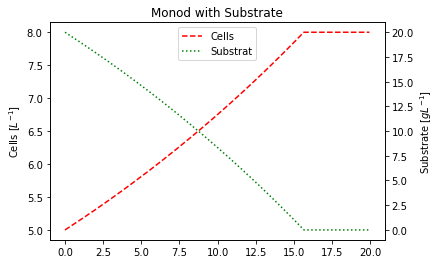

In [3]:
def monod_substrate(x0,S0,ymax,Yxs,t):

    xt = [x0]
    st = [S0]
    tt = [0]

    tstep = 0.05
    tcheck = t/tstep
    
    i = 1
    while i < tcheck:
        xt.append(xt[i-1]*np.exp(ymax*tstep))
        st.append(st[i-1]-(xt[i]*Yxs))
        if st[i] <= 0:
            st[i] = 0 
            xt[i] = xt[i-1]
        tt.append(tstep*i)
        i += 1
    
    ax1 = plt.subplot()
    in1 = ax1.plot(tt,xt, 'r--', label = 'Cells')
    plt.ylabel('Cells $[L^{-1}]$')
    ax2 = ax1.twinx()
    in2 = ax2.plot(tt,st,'g:', label = 'Substrat')
    plt.ylabel('Substrate $[gL^{-1}]$')
    lns = in1+in2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc = 9)
    plt.title('Monod with Substrate')

#---------------------------------#
monod_substrate(5,20,0.03,0.01,20)
#---------------------------------#

The figure above has the issue that it does not take in to account, that the amount of Substrate can't got below 0. Further, the influence of missing substrate is neglected in the shown diagramm. Therefore another model has to be taken in account to describe the monod model.

The parameter $\mu$ should be calculated as follows:
$\mu = \mu_{max}\cdot\dfrac{[S]}{K_s +[S]}  $

Here:

$K_S = $ half-velocity constant 

$[S] =$ Substrate


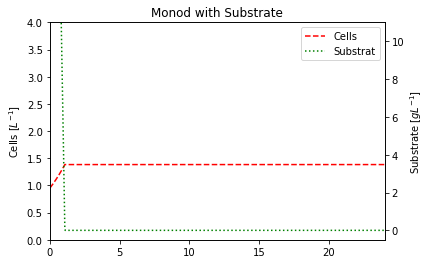

In [10]:
def monod_empirical(x0,S0,ymax,Yxs,Ks, t, tstep = 0.025):
    xt = [x0]
    st = [S0]
    yt = [ymax*(st[0]/Ks+st[0])]
    tt = [0]
    tcheck = t/tstep

    i = 1
    while i < tcheck:
        xt.append(xt[i-1]*np.exp(ymax*tstep))
        st.append(st[i-1]-(xt[i]*Yxs))
        yt.append(ymax*(st[i]/Ks+st[i]))
        if st[i] <= 0:
            st[i] = 0 
            xt[i] = xt[i-1]
            yt[i] = ymax
        tt.append(tstep*i)
        i += 1
        
    ax1 = plt.subplot()
    in1 = ax1.plot(tt,xt, 'r--', label = 'Cells')
    plt.ylabel('Cells $[L^{-1}]$')
    plt.ylim(0,4)
    ax2 = ax1.twinx()
    in2 = ax2.plot(tt,st,'g:', label = 'Substrat')
    plt.ylabel('Substrate $[gL^{-1}]$')
    plt.ylim(-0.5,11)
    lns = in1+in2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc = 1)
    plt.title('Monod with Substrate')
    plt.xlim(0,24)
    
#-----------------------------------------------------------------#       
monod_empirical(0.95,40,0.35,0.8,0.5,24)
#-----------------------------------------------------------------#


### 1.2 Diauxic Growth

Comapred to the monod model the diauxic growth can be used to describe a certain decrease in growth due to uptate of a substrate and shift to another substrate.

To implement this growth behavior an addtional Substrate $S_{1or2}$ is needed each of these substrates has a maximal specific growth rate $\mu_{max_{S1 or S2}}$and a half velocitys constant $K_{1 or 2}$.

The new formed equation would calculate $\mu_{(t)}$ as follows:

$\mu_{(t)}$ = $\mu_{max_{S1}}$$\cdot$$\frac{S_1}{K_1+S_1}$+$\mu_{max_{S2}}$$\cdot$$\frac{S_2}{K_2+S_2 +\frac{S_1^2}{K1}}$

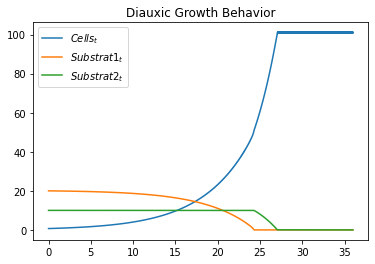

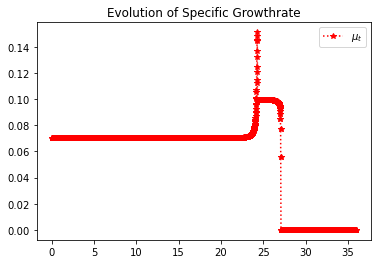

In [136]:
def diauxic_growth(x0,ymax1,ymax2,S1,S2,K1,K2,Yxs1,Yxs2,t,tstep = 0.05):
    #initial conditions
    ST1 = [S1]
    ST2 = [S2]
    XT  = [x0]
    yt  = [ymax1*(S1/(K1+S1))+ymax2*(S2/(K2+S2+(S1**2/K1)))]
    #initialize timesteps
    t = np.arange(t, step = 0.01) #every 0.1min update
    index = 0
    for tt in t:
        XT.append(XT[index-1]*np.exp(yt[index]*tstep)) 
        if XT[index] >0:
            if XT[index] <= XT[index-1]:
                dXT = 0
            else:
                dXT = XT[index]-XT[index-1]
        ST1.append(ST1[index]-((dXT)*Yxs1))
        if ST1[index] <= 0:
            ST2.append(ST2[index]-((dXT)*Yxs2))
            ST1[index]= 0
        elif index == 0:
            ST2.append(ST2[index])
        else:
            ST2.append(ST2[index-1])   
        if ST2[index] <= 0:
            ST2[index] = 0
        yt.append(ymax1*(ST1[index]/(K1+ST1[index]))+ymax2*(ST2[index]/((K2+ST2[index]+(ST1[index]**2/K1)))))
        if yt[index-1] == 0 and index > 0:
            yt[index] = 0           
        index += 1
        
    plt.figure()
    plt.title('Diauxic Growth Behavior')
    plt.plot(t,XT[:-1],label = '$Cells_t$')
    plt.plot(t,ST1[:-1], label = '$Substrat1_t$' )
    plt.plot(t,ST2[:-1], label = '$Substrat2_t$')
    plt.legend()
    
    plt.figure()
    plt.title('Evolution of Specific Growthrate')
    plt.plot(t,yt[:-1], 'r*:' , label = '$\mu_t$' )
    plt.legend()
    #conditions in respect to time
    #print(tt)
    #print(ST1,ST2, XT,yt)
    
        
        
    
diauxic_growth(0.7,0.07, 0.1, 20, 10, 0.03, 0.04, 0.4, 0.2, 36)


# 1.3 Yeast Growth (Budding)
Another interessing growth behavior is the one observed in yeast. Since yeast is budding, scares are formed on the membran and the splitting of yeast to new offspring is limited. By introduceing an $Age$ and $MaxAge$ variable this behavior can be modeled as follows:

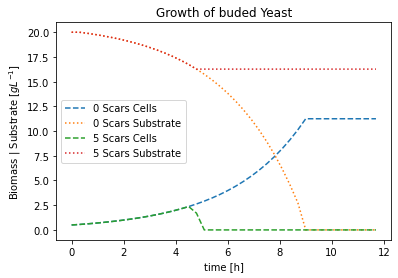

In [69]:
def yeastgrowth(x0,mumax,S0,Yxs,KS,t,Age = 0, MaxAge = 10):
    
    tstep = 0.3
    xt  = [x0]
    st  = [S0]
    mt = [mumax*(S0/(S0+KS))]
    counter = 1
    
    runs = round(t/tstep)
    for i in range(1,runs):
        xt.append(xt[counter-1]*np.exp(tstep*mt[counter-1]))
        st.append(S0-(xt[i-1]-x0)/Yxs)
        mt.append(mumax*(st[i]/st[i]+KS))
        
        if i*mumax > MaxAge-Age:
            xt[i] = (xt[i-1]+(xt[i-1]-xt[i-(MaxAge-Age)])*np.exp(mt[i]*tstep))-xt[i-(MaxAge-Age)]
            st[i] = S0-(xt[i-1]-x0)/Yxs + (st[i-MaxAge-Age]-S0)
            
        if xt[i]<=0:
            xt[i] = 0
            st[i] = st[i-1]
            
        if st[i] < 0:
            st[i] = 0
            st[i-1] = 0
            xt[i] = xt[i-1]

        counter += 1
    tt = np.arange(0,t,tstep)
    
    # plt.subplot()
    plt.plot(tt, xt, '--',label = str(Age)+ ' Scars'+' Cells')
    plt.plot(tt, st, ':',label = str(Age)+ ' Scars'+' Substrate')
    plt.xlabel('time [h]')
    plt.ylabel('Biomass | Substrate [$gL^{-1}$]')
    plt.title('Growth of buded Yeast')
    plt.legend()
          
a1 = yeastgrowth(0.5,0.33,20,0.5,0.05,12, Age = 0)
a2 = yeastgrowth(0.5,0.33,20,0.5,0.05,12, Age = 5)    

# 1.4 Microcarrier Growth
$\href{https://scihub.wikicn.top/10.3390/bioengineering5040106}{Growth Behavior of Human Adipose Tissue-Derived Stromal/Stem Cells at Small Scale: Numerical and Experimental Investigations}$


Allows for another approach of the claculation of $\mu$ as shown in the following equation:


$\mu = \mu_{max}\cdot\frac{Gluc}{K_{Gluc}+Gluc}\cdot\frac{K_{Lac}}{K_{Lac}+Lac}\cdot\frac{K_{Amn}}{K_{Amn}+Amn}\cdot\frac{SA_{max}-SA_{MC}}{SA_{max}}$

Here: 

$Gluc$ = Glucose

$Lac$ = Lactose

$Amn$ = Amoniak

$SA$ = Surfacearea


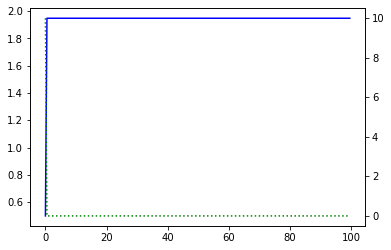

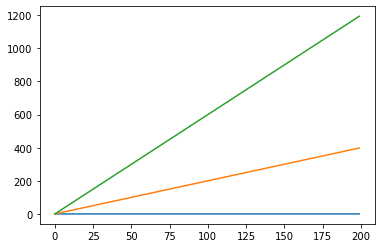

------------------------------------------------
Abomination -> use scipy.integrate to solve this
------------------------------------------------


In [5]:
def monod_jossen(x0, ymax, Glc, Yxg, Ylg = 0.2 , Yag= 0.6, KGlc = 0.4 , KLac = 0.35, KAmn = 0.008, Lac=0.002, Amn=0.001, SA_max=5, dCell = 0.00003, t = 100):
    
    #inital Vlaues
    xt = [x0]
    Gt = [Glc]
    Lt = [Lac]
    At = [Amn]
    St = [SA_max-(xt[0]*dCell)]
    yt = [ymax*(Gt[0]/(KGlc+Gt[0]))*(KLac/(KLac+Lt[0]))*(KAmn/(KAmn+At[0]))*(SA_max-St[0]/SA_max)]

    tstep = 0.5
    runs  = t/tstep 
    
    i = 1
    while i < runs:
        
        xt.append(xt[i-1]*np.exp(yt[i-1]))
        Gt.append(Gt[0]-(xt[i]/Yxg))
        if Gt[i]<=0:
            Gt[i] = 0
        Lt.append(np.abs(np.sum(Gt[i])-Gt[0])*Ylg+Lt[i-1])
        At.append(np.abs(np.sum(Gt[i])-Gt[0])*Yag+At[i-1])
        St.append(xt[i]*dCell)
        yt.append(ymax*(Gt[i]/(KGlc+Gt[i]))*(KLac/(KLac+Lt[i]))*(KAmn/(KAmn+At[i]))*(SA_max-St[i]/SA_max))
        
        i += 1
    
    time = np.arange(0,t,tstep)
    
    ax1 = plt.subplot()
    ax1.plot(time,xt, 'b',label = '$Cells_t$')
    ax2 = ax1.twinx()
    ax2.plot(time,Gt,'g:', label = '$Glucose_t$' )
    
    plt.figure()
    plt.plot(yt)
    plt.plot(Lt)
    plt.plot(At)
       
monod_jossen(0.5,0.4,10,0.004)
plt.show()
print('------------------------------------------------')
print('Abomination -> use scipy.integrate to solve this')
print('------------------------------------------------')

# 1.5 New Library scipy.integrate solve_ivp
## a) Simple Monod
The library $\href{https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html}{scipy.integrate}$ method solve_ivp makes ploting these problems easy since it allows working with differnetial equations.

Beginer level
$\frac{dx}{dt}$ = $x\cdot\mu_t$ 
        
where
        
$\mu_t$ = $\frac{S_t}{S_t+K_S}$ 
        
and
        
$S_t$ = $-\frac{\mu_{max}}{Y_{XS}}*x$

(0.0, 72.0)

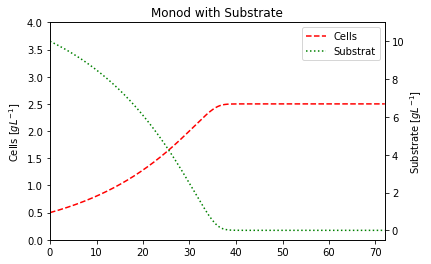

In [29]:
# from scipy.integrate import solve_ivp

#define function
def monod(t, z, mumax, Yxs, Ks):
    x, S = z 
    return [(mumax*(S/(S+Ks))*x),-1*(mumax/Yxs)*(S/(S+Ks))*x]

#solve function
sol = solve_ivp(monod, (0, 72), (0.5,10), args=(0.05,0.2,0.5),t_eval=np.linspace(0,72,720),method = 'BDF')

#plot
ax1  = plt.subplot()
in1  = ax1.plot(sol.t,sol.y[0], 'r--', label = 'Cells')
plt.ylabel('Cells $[gL^{-1}]$')
plt.ylim(0,4)
ax2  = ax1.twinx()
in2  = ax2.plot(sol.t,sol.y[1],'g:', label = 'Substrat')
plt.ylabel('Substrate $[gL^{-1}]$')
plt.ylim(-0.5,11)
lns  = in1+in2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc = 1)
plt.title('Monod with Substrate')
plt.xlim(0,72)
    

## b) Diauxic Growth
For the modeling of diauxic growth the scipy kit has socalled events which will be used to provide 

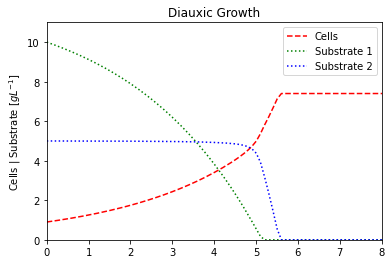

In [126]:
#function
def diauxic_growth (t, cells, mumax1, mumax2, Yxs1,Yxs2,K1,K2):
    x,S1,S2 = cells
    return[x*((mumax1*(S1/(S1+K1)))+mumax2*(S2/(S2+K2+(S1**2/K1)))),-1*((mumax1*(S1/(S1+K1)))/Yxs1*x),-1*(mumax2*(S2/(S2+K2+(S1**2/K1)))/Yxs2*x)]

#solve
sol = solve_ivp(diauxic_growth,(0,72),(0.9,10,5),args = (0.33,0.7,0.4,0.5,0.05,0.05),t_eval = np.linspace(0,72,720), method = 'BDF')

#ploting
plt.figure()
in1 = plt.plot(sol.t,sol.y[0], 'r--',label = 'Cells')
plt.ylabel('Cells | Substrate [$gL^{-1}$]')
plt.ylim(0,10)
plt.plot(sol.t,sol.y[1], 'g:', label = 'Substrate 1')
plt.plot(sol.t,sol.y[2], 'b:', label = 'Substrate 2')
plt.ylim(0,11)
plt.legend(loc =1)
plt.xlim(0,8)
plt.title('Diauxic Growth')
plt.show()

## c) Microcarrier Growth

Here the calculation of $\mu_t$ is formulated as follows:

$$\mu_t = \mu_{max}\cdot(\frac{Glc}{Glc+K_{Glc}})\cdot(\frac{K_{Lac}}{Lac+K_{Lac}})\cdot(\frac{K_{Amn}}{Amn+K_{Amn}})\cdot(\frac{X_{max}-X_{MC}}{X_{max}})$$

### With the following derivatives to describe the function above:

The amount of Cells on Microcarriers over time

$\frac{dX_{MC}}{dt} = \mu_t\cdot X_{MC}+k_{at}\cdot\frac{X_{max}-X_{MC}}{X_{max}}X_{Sus}-k_{det}\cdot X_{MC}$

The amount of Cells in Suspention over time

$\frac{dX_{Sus}}{dt} = k_{det}\cdot X_{MC}-k_{at}\cdot\frac{X_{max}-X_{MC}}{X_{max}}X_{Sus}$

The amount of available glucose over time

$\frac{dGlc}{dt} = - \frac{1}{Y_{X/Glc}}\cdot \mu_{max}\cdot(\frac{Glc}{Glc+K_{Glc}})\cdot(\frac{K_{Lac}}{Lac+K_{Lac}})\cdot(\frac{K_{Amn}}{Amn+K_{Amn}})\cdot(\frac{X_{max}-X_{MC}}{X_{max}}) - m_{Glc}\cdot \sigma \cdot X_V$

with $\sigma = [\frac{1\space for \space Glc \space > \space 0}{0\space for \space Glc \space <= \space 0}$

and $X_V = X_{MC} + X_{Sus}$

The Amount of metabolites can be caluclated as shown here

$\frac{dLac}{dt} = q_{lac}\cdot \mu_t \cdot X_{MC}$ 

and 

$\frac{dAmn}{dt} = q_{Amn}\cdot \mu_t \cdot X_{MC}$


Values for $Y_{x/Glc}$, and $m_{Glc}$ have been choosen by gut feeling


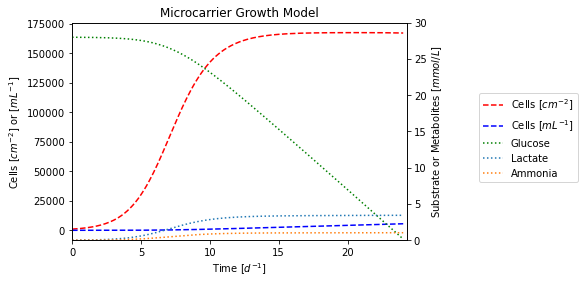

-----------------------------------------------------------------------------------------
       Observation       Unit
Cells on Mircocarriers [Cells/cm2] : 167381 Cells after 24 days
        Floating Cells [Cells/mL]  : 5541 Cells after 24 days
               Glucose [mmol/L]    : 0 Glucose after 24 days
               Lactate [mmol/L]    : 3 Lactate after 24 days
               Ammonia [mmol/L]    : 1 Ammonia after 24 days
-----------------------------------------------------------------------------------------


In [2]:
#function
def mc_growth(t,cells, mumax, Xmax, kat, kdet, Yxglc, Kglc, Klac, Kamn, mglc, qlac, qamn):
    Xmc, Xsus, Glc, Lac, Amn = cells
    
    return[Xmc*mumax*(Glc/(Kglc+Glc))*(Klac/(Lac+Klac))*(Kamn/(Amn+Kamn))*((Xmax-Xmc)/Xmax)-kdet*Xmc, (Xmc*kdet)-(kat*((Xmax-Xmc)/Xmax)*Xsus),-1*(1/Yxglc)*mumax*(Glc/(Kglc+Glc))*(Klac/(Lac+Klac))*(Kamn/(Amn+Kamn))*((Xmax-Xmc)/Xmax)-mglc*(Xmc+Xsus), qlac*mumax*(Glc/(Kglc+Glc))*(Klac/(Lac+Klac))*(Kamn/(Amn+Kamn))*((Xmax-Xmc)/Xmax)*Xmc, qamn*mumax*(Glc/(Kglc+Glc))*(Klac/(Lac+Klac))*(Kamn/(Amn+Kamn))*((Xmax-Xmc)/Xmax)*Xmc]

#termination condition -> no more glucose available
def glucose_depleted(t,cells, mumax, Xmax, kat, kdet, Yxglc, Kglc, Klac, Kamn, mglc, qlac, qamn): return cells[2]
glucose_depleted.terminal = True


#solve
sol = solve_ivp(mc_growth,(0,72),(1000,0,28,0,0),events=glucose_depleted ,args = (0.74,168000,0.033,0.002,3000,0.4,35,8,9.8*10**(-6),20*10**(-6),6*10**(-6)), t_eval= np.linspace(0,72,720), method = 'BDF')

#plot everything
ax1  = plt.subplot()
in1  = ax1.plot(sol.t,sol.y[0], 'r--', label = 'Cells [$cm^{-2}$]')
in2  = ax1.plot(sol.t,sol.y[1], 'b--', label = 'Cells [$mL^{-1}$]')
plt.ylabel('Cells [$cm^{-2}$] or [$mL^{-1}$]')
plt.xlabel('Time [$d^{-1}$]')
ax2  = ax1.twinx()
in3  = ax2.plot(sol.t,sol.y[2],'g:', label = 'Glucose')
in4  = ax2.plot(sol.t,sol.y[3],':', label = 'Lactate')
in5  = ax2.plot(sol.t,sol.y[4],':', label = 'Ammonia')
plt.ylabel('Substrate or Metabolites [$mmol/L$]')
plt.ylim(0,30)
lns  = in1+in2+in3+in4+in5
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, bbox_to_anchor=(1.2, 0.7), loc='upper left')
plt.title('Microcarrier Growth Model')
plt.xlim(0,24.3)
plt.show()

print('-----------------------------------------------------------------------------------------')
print(f'       Observation       Unit')
print(f'Cells on Mircocarriers [Cells/cm2] : {round(max(sol.y[0]))} Cells after {round(max(sol.t))} days')
print(f'        Floating Cells [Cells/mL]  : {round(max(sol.y[1]))} Cells after {round(max(sol.t))} days')
print(f'               Glucose [mmol/L]    : {round(min(sol.y[2]))} Glucose after {round(max(sol.t))} days')
print(f'               Lactate [mmol/L]    : {round(max(sol.y[3]))} Lactate after {round(max(sol.t))} days')
print(f'               Ammonia [mmol/L]    : {round(max(sol.y[4]))} Ammonia after {round(max(sol.t))} days')
print('-----------------------------------------------------------------------------------------')

# Stochastic Model

Initially this a 3 state process was created on paper and the following state transion probabilies where choosen by one good thiking. Finally the transionmatrix was generated
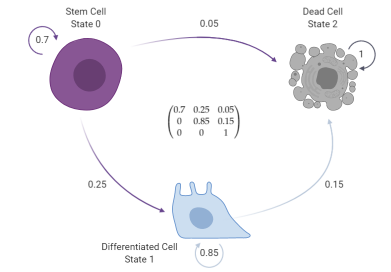
Then a consinous Markov Chain model was created using the below shown recursiv function to model this process to understand the change of states from one cell typ to another and finally in the absorpion state where we a talking about dead cells. The function was writen to stop calculating, when there are no more stem cells or when there where more then 2500 recursiv calls.


It worked no more stem cells after  268 generations.


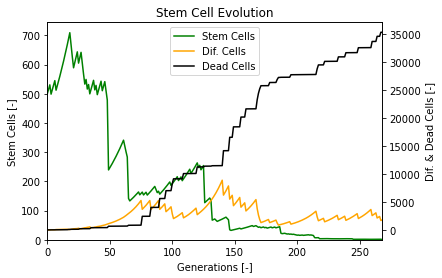

In [4]:
Stemcells   = [500]
DiCells     = [0]
DeadCells   = [0]

TransitionMatrix = [[0.7, 0.25, 0.05],[0, 0.85, 0.15],[0, 0, 1]]

Br = [0.03,0.06,0]
Dr = [0.5,0.3,0]

def stoch_growth(StemCells,DiCells,DeadCells,TransitionMatrix,Br,Dr,GN=0):
    
    #figure out if the function might still recompute
    if Stemcells[GN]<1 or GN > 2500:
        print(f'It worked no more stem cells after {GN:4} generations.')
        ax1 = plt.subplot()
        ins1 = ax1.plot(StemCells, 'g', label='Stem Cells')
        plt.ylabel('Stem Cells [-]')
        plt.ylim(0)
        plt.xlim(0,GN)
        plt.xlabel('Generations [-]')
        ax2 = ax1.twinx()
        ins2 = ax2.plot(DiCells, 'orange',label = 'Dif. Cells')
        ins3 = ax2.plot(DeadCells, 'k', label = 'Dead Cells')
        plt.ylabel('Dif. & Dead Cells [-]')
        # plt.ylim(0,2e10)
        ins = ins1 + ins2 + ins3
        labs = [l.get_label () for l in ins]
        ax1.legend(ins , labs, loc = 9)
        plt.title('Stem Cell Evolution')
        plt.show()
        #print(Stemcells)
        return
     
    SCC = np.random.choice(3,1,p=[TransitionMatrix[0][0],TransitionMatrix[0][1],TransitionMatrix[0][2]])
    DCC = np.random.choice(2,1,p=[TransitionMatrix[1][1],TransitionMatrix[1][2]])
    #print(f'SCC = {SCC}')
    #print(f'DCC = {DCC}')
    
    #updating every State in reversed order to ensure maximal number of available cells
    newDeadCells1 = 1
    newDeadCells2 = 1
    addnewDiCells = 1
    
    if SCC == 0:
        newStemcells    = Stemcells[GN]*Br[0]
    elif SCC ==2:
        newStemcells    = -Stemcells[GN]*Dr[0]
        newDeadCells1    = Stemcells[GN]*Dr[0]
    else:
        addnewDiCells   = Stemcells[GN]*Br[1]
        newStemcells    = -Stemcells[GN]*Br[1]
          
    if DCC == 0:
        newDiCells      = DiCells[GN]*Br[1]
    else:
        newDiCells      = -DiCells[GN]*Dr[1]
        newDeadCells2    = DiCells[GN]*Dr[1]
    
    StemCells.append(Stemcells[GN]+newStemcells)
    DiCells.append(DiCells[GN]+newDiCells+addnewDiCells)
    DeadCells.append(DeadCells[GN]+newDeadCells1+newDeadCells2)
    GN += 1
    return stoch_growth(StemCells,DiCells,DeadCells,TransitionMatrix,Br,Dr,GN)

#----------------------------------------------------------------------------#
stoch_growth(Stemcells,DiCells,DeadCells,TransitionMatrix,Br,Dr,0)
#----------------------------------------------------------------------------#
